## Importing Libraries

In [483]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

## Constant Declaration

In [484]:
class FeatureCategory:
    CATEGORICAL = 1
    NUMERICAL = 2
    ORDINAL = 3

num_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', \
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', \
                 '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', \
                 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', \
                 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', \
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', \
                 'MiscVal', 'MoSold', 'YrSold']

cat_features = ['MSZoning', 'Street', 'Alley', \
                'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', \
                'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', \
                'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', \
                'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', \
                'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', \
                'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', \
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', \
                'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition' ]

ord_features = ['MSSubClass', 'OverallQual', 'OverallCond' ]

## Classes

In [485]:
class FeatureAnalysis:
    
    def analyse_missing_features(self, df, feature_list, to_impute):
        if (to_impute):
            return df[feature_list] \
                    .isnull().mean() \
                    .loc[lambda x : x > 0] \
                    .sort_values(ascending=False)
        else:
            return df[feature_list] \
                    .isnull().mean() \
                    .loc[lambda x : x == 0] \
                    .sort_values(ascending=False)
            
            
    
    def unique_values(self, df, feature_name):
        feature_values = df[feature_name].unique()
        feature_values.sort()
        return feature_values
    
    def draw_feature_plots(self, df, feature_name, target_name, is_categorical):
        feature = df[feature_name]
        fig, axs = plt.subplots(2, 2)
        fig.suptitle(f'"{feature_name}" feature analysis')

        axs[0, 0].hist(feature)
        
        if (is_categorical == False):
            axs[0, 1].boxplot(feature)
    
        stats.probplot(df[feature_name], dist='norm', plot=axs[1, 0])
        
        if (not (target_name == '')):
            axs[1, 1].scatter(feature, df[target_name])

        plt.show()
    

## Loading training and testing sets

In [486]:
train_df = pd.read_csv('../datasets/house_prices/train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [487]:
test_df = pd.read_csv('../datasets/house_prices/test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [488]:
print('Number of FEATURES = ' + str(len(train_df.columns)))
print('Number of ROWS = ' + str(len(train_df)))
print('Number of the NUMERICAL features = ' + str(len(num_features)))
print('Number of the CATEGORICAL features = ' + str(len(cat_features)))
print('Number of the ORDINAL features = ' + str(len(ord_features)))
print('All FEATURES = ' + str(train_df.columns.values))

Number of FEATURES = 81
Number of ROWS = 1460
Number of the NUMERICAL features = 33
Number of the CATEGORICAL features = 43
Number of the ORDINAL features = 3
All FEATURES = ['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 

In [489]:
fa = FeatureAnalysis()

## Feature imputation

In [490]:
imputed_features = []
imputed_train_df = pd.DataFrame()
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [491]:
num_features_to_impute = fa.analyse_missing_features(train_df, num_features, True)
num_features_no_impute = fa.analyse_missing_features(train_df, num_features, False)

imputed_features.append(num_features_no_impute.index)
imputed_train_df = pd.concat([imputed_train_df, train_df[num_features_no_impute.index]])

train_df[num_features_to_impute.index].head()

,LotFrontage,GarageYrBlt,MasVnrArea
0,65.0,2003.0,196.0
1,80.0,1976.0,0.0
2,68.0,2001.0,162.0
3,60.0,1998.0,0.0
4,84.0,2000.0,350.0


In [492]:
len(imputed_train_df)

1460

In [493]:
median_imputer.fit(train_df[num_features_to_impute.index])
num_features_imputed = median_imputer.transform(train_df[num_features_to_impute.index])
num_features_imputed_df = pd.DataFrame(num_features_imputed, columns=num_features_to_impute.index)

for column in num_features_imputed_df.columns:
    imputed_train_df[column] = num_features_imputed_df[column]
    
#print(str(len(imputed_train_df.columns)))
imputed_train_df.head()

,LotArea,YearBuilt,MoSold,MiscVal,PoolArea,ScreenPorch,3SsnPorch,EnclosedPorch,OpenPorchSF,WoodDeckSF,...,1stFlrSF,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinSF1,YearRemodAdd,YrSold,LotFrontage,GarageYrBlt,MasVnrArea
0,8450,2003,2,0,0,0,0,0,61,0,...,856,856,150,0,706,2003,2008,65.0,2003.0,196.0
1,9600,1976,5,0,0,0,0,0,0,298,...,1262,1262,284,0,978,1976,2007,80.0,1976.0,0.0
2,11250,2001,9,0,0,0,0,0,42,0,...,920,920,434,0,486,2002,2008,68.0,2001.0,162.0
3,9550,1915,2,0,0,0,0,272,35,0,...,961,756,540,0,216,1970,2006,60.0,1998.0,0.0
4,14260,2000,12,0,0,0,0,0,84,192,...,1145,1145,490,0,655,2000,2008,84.0,2000.0,350.0


In [494]:
num_features_to_impute = fa.analyse_missing_features(imputed_train_df, num_features, True)
num_features_to_impute

Series([], dtype: float64)

<AxesSubplot: >

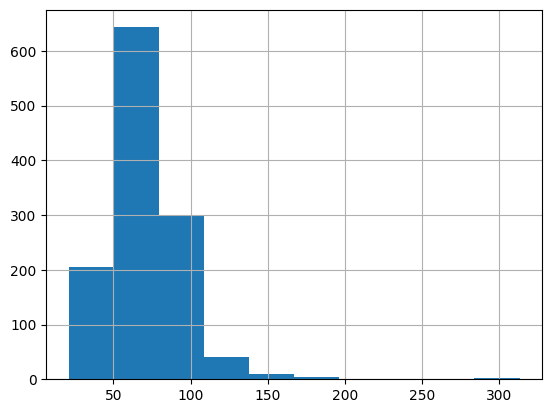

In [502]:
#fa.draw_feature_plots(train_df, 'MasVnrArea', 'SalePrice', False)
#stats.probplot(train_df['MSSubClass'], dist='norm', plot=plt)
#plt.show()
train_df['LotFrontage'].hist()

<AxesSubplot: >

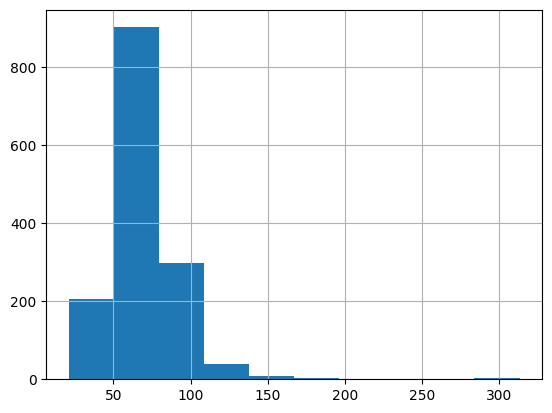

In [503]:
imputed_train_df['LotFrontage'].hist()